# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
64 nodes added Convolutional AE, 128x128x3

## 0. Setting

### Goole Drive Connecting

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [ ]:
!ls

 data  'Fashion Recommendation System0810.ipynb'   figure  'low version'


In [ ]:
!unzip Fashion_train_modelimages.zip

In [ ]:
!unzip Fashion_train_itemimages.zip

### Library Call

In [ ]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pydot

In [ ]:
pip install graphviz

In [ ]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Init Plugin
Init Graph Optimizer
Init Kernel


### User Function Definition

In [ ]:
import os
os.getcwd()

'/Users/haesik/AISCHOOL/Final_Project/img'

In [ ]:
root_dir = '/Users/haesik/AISCHOOL/Final_Project/img/Item-Image/'
# glob(f'{root_dir}/*.jpg')

In [ ]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 128
imgC = 128
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/Users/haesik/AISCHOOL/Final_Project/img/Item-Image/'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# Load All img from folder
def load_img_folder():
    # 의상의 전방부 사진만 가져오기
    wfiles = sorted(glob(f'{root_dir}/*_F.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# -------------Image EDA & Visualization ------------- #
# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()

# ------------- Model Function ------------- #
# Reconstruction Error Function Definition
def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

# Average Pooling Fuction Definition
def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

## 1. Data Load

In [ ]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (16585, 128, 128, 3)
label_set.shape : 16585


In [ ]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 215.1488)

In [ ]:
# Label Information
type(label_set), label_set[:4]

(list, ['0928015_F.jpg', '0929029_F.jpg', '1008001_F.jpg', '1008004_F.jpg'])

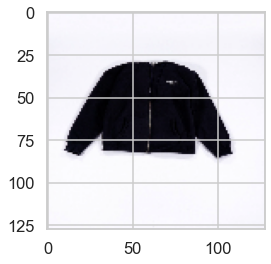

In [ ]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

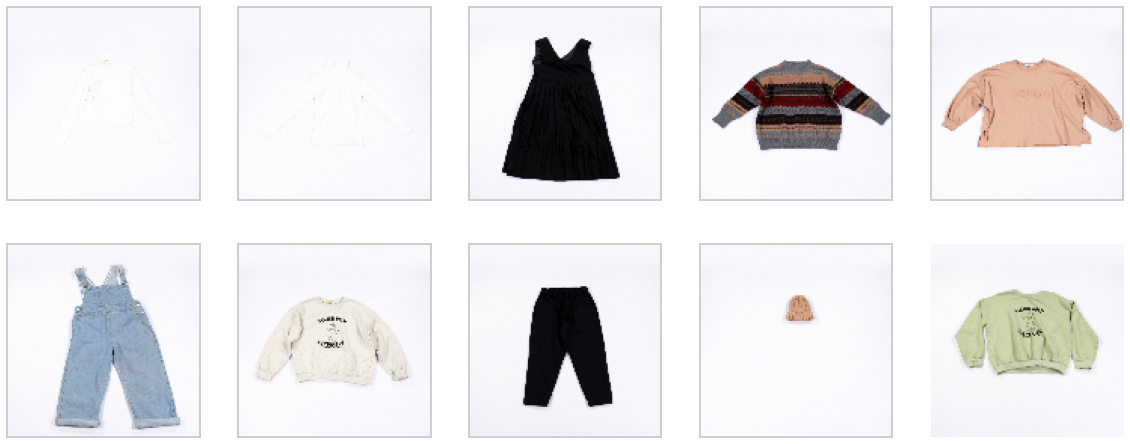

In [ ]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [ ]:
# Data Normalization
img_scaled = img_set / 255.0
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (16585, 128, 128, 3) 215.1488384048635
Scaled Image Format : (16585, 128, 128, 3) 0.8437209349210284


In [ ]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(13268, 128, 128, 3) 13268
(3317, 128, 128, 3) 3317


## 3. Convolutional Autoencoder Modeling

### Encoder

In [ ]:
# Encoder Part Modeling
tensorflow.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

# Fisrt ConvPooling Layer : 128
L1 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)

# Second ConvPooling Layer : 64
L3 = Conv2D(64, (3, 3), activation='relu', padding='same')(L2)
L4 = Conv2D(64, (3, 3), activation='relu', padding='same')(L3)
L5 = BatchNormalization()(L4)
L6 = MaxPooling2D((2, 2))(L5)

# Third ConvPooling Layer : 32
L7 = Conv2D(32, (3, 3), activation='relu', padding='same')(L6)
L8 = Conv2D(32, (3, 3), activation='relu', padding='same')(L7)
L9 = BatchNormalization()(L8)
L10 = MaxPooling2D((2, 2))(L9)

# Fourth ConvPooling Layer : 16
L11 = Conv2D(16, (3, 3), activation='relu', padding='same')(L10)
L12 = Conv2D(16, (3, 3), activation='relu', padding='same')(L11)
L13 = BatchNormalization()(L12)
L14 = MaxPooling2D((2, 2))(L13)

# Fifth ConvPooling Layer : 8
L15 = Conv2D(8, (3, 3), activation='relu', padding='same')(L14)
L16 = MaxPooling2D((2, 2))(L15)

encoder_output = L16

Metal device set to: Apple M1 Pro


2022-08-17 20:01:47.700560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-17 20:01:47.701280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Encoder Summary()
encoder = tensorflow.keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 42,504
Trainable params: 42,376
Non-trainable params: 128
_________________________________________________________________


In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Decoder

In [ ]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

# First ConvPooling Layer : 8
L17 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L18 = UpSampling2D((2, 2))(L17)

# Second ConvPooling Layer : 16
L19 = Conv2D(16, (3, 3), activation='relu', padding='same')(L18)
L20 = Conv2D(16, (3, 3), activation='relu', padding='same')(L19)
L21 = BatchNormalization()(L20)
L22 = UpSampling2D((2, 2))(L21)

# Third ConvPooling Layer : 32
L23 = Conv2D(32, (3, 3), activation='relu', padding='same')(L22)
L24 = Conv2D(32, (3, 3), activation='relu', padding='same')(L23)
L25 = BatchNormalization()(L24)
L26 = UpSampling2D((2, 2))(L25)

# Fourth ConvPooling Layer : 64
L27 = Conv2D(64, (3, 3), activation='sigmoid', padding='same')(L26)
L28 = Conv2D(64, (3, 3), activation='relu', padding='same')(L27)
L29 = BatchNormalization()(L28)
L30 = UpSampling2D((2, 2))(L29)

# Fifth ConvPooling Layer : 128
L31 = Conv2D(128, (3, 3), activation='sigmoid', padding='same')(L30)
L32 = UpSampling2D((2, 2))(L31)

# Sixth ConvPooling Layer : 3
L33 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L32)

decoder_output = L33

In [ ]:
# Decoder Summary()
decoder = tensorflow.keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 43,083
Trainable params: 42,955
Non-trainable params: 128
_________________________________________________________________


In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### AutoEncoder (Encoder + Decoder)

In [ ]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = tensorflow.keras.Model(init_input, connect_output)

In [ ]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [ ]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 85,587
Trainable params: 85,331
Non-trainable params: 256
_________________________________________________________________


In [ ]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 64

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|  0/100 ETA: ?s,  ?epoch

Epoch 1/100
Epoch 1/100


2022-08-17 20:02:31.963837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-17 20:02:31.971731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0/197                        ETA: ?s - 

2022-08-17 20:02:32.644272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.3422

2022-08-17 20:03:44.990170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 75s 352ms/step - loss: 0.3422 - val_loss: 0.2596

Epoch 00001: val_loss improved from inf to 0.25958, saving model to Training-checkpoint/cp-0001-0.26.ckpt
Epoch 2/100
Epoch 2/100


0/197                        ETA: ?s - 

197/197 [==============================] - 67s 341ms/step - loss: 0.2474 - val_loss: 0.2456

Epoch 00002: val_loss improved from 0.25958 to 0.24558, saving model to Training-checkpoint/cp-0002-0.25.ckpt
Epoch 3/100
Epoch 3/100


0/197                        ETA: ?s - 

197/197 [==============================] - 67s 339ms/step - loss: 0.2379 - val_loss: 0.2387

Epoch 00003: val_loss improved from 0.24558 to 0.23871, saving model to Training-checkpoint/cp-0003-0.24.ckpt
Epoch 4/100
Epoch 4/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2334 - val_loss: 0.2349

Epoch 00004: val_loss improved from 0.23871 to 0.23494, saving model to Training-checkpoint/cp-0004-0.23.ckpt
Epoch 5/100
Epoch 5/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 330ms/step - loss: 0.2306 - val_loss: 0.2339

Epoch 00005: val_loss improved from 0.23494 to 0.23388, saving model to Training-checkpoint/cp-0005-0.23.ckpt
Epoch 6/100
Epoch 6/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2285 - val_loss: 0.2333

Epoch 00006: val_loss improved from 0.23388 to 0.23329, saving model to Training-checkpoint/cp-0006-0.23.ckpt
Epoch 7/100
Epoch 7/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 336ms/step - loss: 0.2276 - val_loss: 0.2307

Epoch 00007: val_loss improved from 0.23329 to 0.23065, saving model to Training-checkpoint/cp-0007-0.23.ckpt
Epoch 8/100
Epoch 8/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2261 - val_loss: 0.2291

Epoch 00008: val_loss improved from 0.23065 to 0.22909, saving model to Training-checkpoint/cp-0008-0.23.ckpt
Epoch 9/100
Epoch 9/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2255 - val_loss: 0.2285

Epoch 00009: val_loss improved from 0.22909 to 0.22849, saving model to Training-checkpoint/cp-0009-0.23.ckpt
Epoch 10/100
Epoch 10/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2248 - val_loss: 0.2280

Epoch 00010: val_loss improved from 0.22849 to 0.22805, saving model to Training-checkpoint/cp-0010-0.23.ckpt
Epoch 11/100
Epoch 11/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 329ms/step - loss: 0.2246 - val_loss: 0.2279

Epoch 00011: val_loss improved from 0.22805 to 0.22786, saving model to Training-checkpoint/cp-0011-0.23.ckpt
Epoch 12/100
Epoch 12/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 329ms/step - loss: 0.2237 - val_loss: 0.2274

Epoch 00012: val_loss improved from 0.22786 to 0.22741, saving model to Training-checkpoint/cp-0012-0.23.ckpt
Epoch 13/100
Epoch 13/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2238 - val_loss: 0.2265

Epoch 00013: val_loss improved from 0.22741 to 0.22650, saving model to Training-checkpoint/cp-0013-0.23.ckpt
Epoch 14/100
Epoch 14/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2229 - val_loss: 0.2259

Epoch 00014: val_loss improved from 0.22650 to 0.22585, saving model to Training-checkpoint/cp-0014-0.23.ckpt
Epoch 15/100
Epoch 15/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2224 - val_loss: 0.2262

Epoch 00015: val_loss did not improve from 0.22585
Epoch 16/100
Epoch 16/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2221 - val_loss: 0.2251

Epoch 00016: val_loss improved from 0.22585 to 0.22513, saving model to Training-checkpoint/cp-0016-0.23.ckpt
Epoch 17/100
Epoch 17/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2219 - val_loss: 0.2250

Epoch 00017: val_loss improved from 0.22513 to 0.22504, saving model to Training-checkpoint/cp-0017-0.23.ckpt
Epoch 18/100
Epoch 18/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2214 - val_loss: 0.2246

Epoch 00018: val_loss improved from 0.22504 to 0.22459, saving model to Training-checkpoint/cp-0018-0.22.ckpt
Epoch 19/100
Epoch 19/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2214 - val_loss: 0.2254

Epoch 00019: val_loss did not improve from 0.22459
Epoch 20/100
Epoch 20/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2210 - val_loss: 0.2248

Epoch 00020: val_loss did not improve from 0.22459
Epoch 21/100
Epoch 21/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2211 - val_loss: 0.2239

Epoch 00021: val_loss improved from 0.22459 to 0.22391, saving model to Training-checkpoint/cp-0021-0.22.ckpt
Epoch 22/100
Epoch 22/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2209 - val_loss: 0.2241

Epoch 00022: val_loss did not improve from 0.22391
Epoch 23/100
Epoch 23/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 329ms/step - loss: 0.2205 - val_loss: 0.2244

Epoch 00023: val_loss did not improve from 0.22391
Epoch 24/100
Epoch 24/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2203 - val_loss: 0.2240

Epoch 00024: val_loss did not improve from 0.22391
Epoch 25/100
Epoch 25/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2200 - val_loss: 0.2236

Epoch 00025: val_loss improved from 0.22391 to 0.22361, saving model to Training-checkpoint/cp-0025-0.22.ckpt
Epoch 26/100
Epoch 26/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 330ms/step - loss: 0.2197 - val_loss: 0.2230

Epoch 00026: val_loss improved from 0.22361 to 0.22296, saving model to Training-checkpoint/cp-0026-0.22.ckpt
Epoch 27/100
Epoch 27/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 324ms/step - loss: 0.2198 - val_loss: 0.2229

Epoch 00027: val_loss improved from 0.22296 to 0.22287, saving model to Training-checkpoint/cp-0027-0.22.ckpt
Epoch 28/100
Epoch 28/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 333ms/step - loss: 0.2200 - val_loss: 0.2244

Epoch 00028: val_loss did not improve from 0.22287
Epoch 29/100
Epoch 29/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 334ms/step - loss: 0.2209 - val_loss: 0.2236

Epoch 00029: val_loss did not improve from 0.22287
Epoch 30/100
Epoch 30/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2198 - val_loss: 0.2225

Epoch 00030: val_loss improved from 0.22287 to 0.22247, saving model to Training-checkpoint/cp-0030-0.22.ckpt
Epoch 31/100
Epoch 31/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 333ms/step - loss: 0.2195 - val_loss: 0.2235

Epoch 00031: val_loss did not improve from 0.22247
Epoch 32/100
Epoch 32/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 333ms/step - loss: 0.2191 - val_loss: 0.2224

Epoch 00032: val_loss improved from 0.22247 to 0.22238, saving model to Training-checkpoint/cp-0032-0.22.ckpt
Epoch 33/100
Epoch 33/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2195 - val_loss: 0.2232

Epoch 00033: val_loss did not improve from 0.22238
Epoch 34/100
Epoch 34/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2187 - val_loss: 0.2224

Epoch 00034: val_loss improved from 0.22238 to 0.22237, saving model to Training-checkpoint/cp-0034-0.22.ckpt
Epoch 35/100
Epoch 35/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 334ms/step - loss: 0.2186 - val_loss: 0.2224

Epoch 00035: val_loss did not improve from 0.22237
Epoch 36/100
Epoch 36/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 336ms/step - loss: 0.2189 - val_loss: 0.2225

Epoch 00036: val_loss did not improve from 0.22237
Epoch 37/100
Epoch 37/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2188 - val_loss: 0.2222

Epoch 00037: val_loss improved from 0.22237 to 0.22220, saving model to Training-checkpoint/cp-0037-0.22.ckpt
Epoch 38/100
Epoch 38/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2184 - val_loss: 0.2224

Epoch 00038: val_loss did not improve from 0.22220
Epoch 39/100
Epoch 39/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2183 - val_loss: 0.2224

Epoch 00039: val_loss did not improve from 0.22220
Epoch 40/100
Epoch 40/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 336ms/step - loss: 0.2185 - val_loss: 0.2227

Epoch 00040: val_loss did not improve from 0.22220
Epoch 41/100
Epoch 41/100


0/197                        ETA: ?s - 

197/197 [==============================] - 67s 339ms/step - loss: 0.2180 - val_loss: 0.2239

Epoch 00041: val_loss did not improve from 0.22220
Epoch 42/100
Epoch 42/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2181 - val_loss: 0.2215

Epoch 00042: val_loss improved from 0.22220 to 0.22152, saving model to Training-checkpoint/cp-0042-0.22.ckpt
Epoch 43/100
Epoch 43/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2178 - val_loss: 0.2226

Epoch 00043: val_loss did not improve from 0.22152
Epoch 44/100
Epoch 44/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2178 - val_loss: 0.2218

Epoch 00044: val_loss did not improve from 0.22152
Epoch 45/100
Epoch 45/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2175 - val_loss: 0.2215

Epoch 00045: val_loss improved from 0.22152 to 0.22150, saving model to Training-checkpoint/cp-0045-0.22.ckpt
Epoch 46/100
Epoch 46/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2178 - val_loss: 0.2211

Epoch 00046: val_loss improved from 0.22150 to 0.22112, saving model to Training-checkpoint/cp-0046-0.22.ckpt
Epoch 47/100
Epoch 47/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2174 - val_loss: 0.2207

Epoch 00047: val_loss improved from 0.22112 to 0.22072, saving model to Training-checkpoint/cp-0047-0.22.ckpt
Epoch 48/100
Epoch 48/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2171 - val_loss: 0.2212

Epoch 00048: val_loss did not improve from 0.22072
Epoch 49/100
Epoch 49/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2174 - val_loss: 0.2204

Epoch 00049: val_loss improved from 0.22072 to 0.22041, saving model to Training-checkpoint/cp-0049-0.22.ckpt
Epoch 50/100
Epoch 50/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2170 - val_loss: 0.2204

Epoch 00050: val_loss improved from 0.22041 to 0.22040, saving model to Training-checkpoint/cp-0050-0.22.ckpt
Epoch 51/100
Epoch 51/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2172 - val_loss: 0.2207

Epoch 00051: val_loss did not improve from 0.22040
Epoch 52/100
Epoch 52/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 325ms/step - loss: 0.2169 - val_loss: 0.2200

Epoch 00052: val_loss improved from 0.22040 to 0.22000, saving model to Training-checkpoint/cp-0052-0.22.ckpt
Epoch 53/100
Epoch 53/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2168 - val_loss: 0.2205

Epoch 00053: val_loss did not improve from 0.22000
Epoch 54/100
Epoch 54/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2169 - val_loss: 0.2203

Epoch 00054: val_loss did not improve from 0.22000
Epoch 55/100
Epoch 55/100


0/197                        ETA: ?s - 

197/197 [==============================] - 62s 315ms/step - loss: 0.2167 - val_loss: 0.2207

Epoch 00055: val_loss did not improve from 0.22000
Epoch 56/100
Epoch 56/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2167 - val_loss: 0.2198

Epoch 00056: val_loss improved from 0.22000 to 0.21984, saving model to Training-checkpoint/cp-0056-0.22.ckpt
Epoch 57/100
Epoch 57/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 329ms/step - loss: 0.2164 - val_loss: 0.2199

Epoch 00057: val_loss did not improve from 0.21984
Epoch 58/100
Epoch 58/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 334ms/step - loss: 0.2169 - val_loss: 0.2199

Epoch 00058: val_loss did not improve from 0.21984
Epoch 59/100
Epoch 59/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2164 - val_loss: 0.2208

Epoch 00059: val_loss did not improve from 0.21984
Epoch 60/100
Epoch 60/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2161 - val_loss: 0.2203

Epoch 00060: val_loss did not improve from 0.21984
Epoch 61/100
Epoch 61/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2163 - val_loss: 0.2198

Epoch 00061: val_loss improved from 0.21984 to 0.21982, saving model to Training-checkpoint/cp-0061-0.22.ckpt
Epoch 62/100
Epoch 62/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2164 - val_loss: 0.2199

Epoch 00062: val_loss did not improve from 0.21982
Epoch 63/100
Epoch 63/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2162 - val_loss: 0.2195

Epoch 00063: val_loss improved from 0.21982 to 0.21945, saving model to Training-checkpoint/cp-0063-0.22.ckpt
Epoch 64/100
Epoch 64/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2163 - val_loss: 0.2193

Epoch 00064: val_loss improved from 0.21945 to 0.21931, saving model to Training-checkpoint/cp-0064-0.22.ckpt
Epoch 65/100
Epoch 65/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2160 - val_loss: 0.2201

Epoch 00065: val_loss did not improve from 0.21931
Epoch 66/100
Epoch 66/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2159 - val_loss: 0.2195

Epoch 00066: val_loss did not improve from 0.21931
Epoch 67/100
Epoch 67/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2160 - val_loss: 0.2193

Epoch 00067: val_loss improved from 0.21931 to 0.21928, saving model to Training-checkpoint/cp-0067-0.22.ckpt
Epoch 68/100
Epoch 68/100


0/197                        ETA: ?s - 

197/197 [==============================] - 70s 355ms/step - loss: 0.2160 - val_loss: 0.2193

Epoch 00068: val_loss improved from 0.21928 to 0.21927, saving model to Training-checkpoint/cp-0068-0.22.ckpt
Epoch 69/100
Epoch 69/100


0/197                        ETA: ?s - 

197/197 [==============================] - 108s 549ms/step - loss: 0.2157 - val_loss: 0.2193

Epoch 00069: val_loss did not improve from 0.21927
Epoch 70/100
Epoch 70/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 336ms/step - loss: 0.2158 - val_loss: 0.2193

Epoch 00070: val_loss did not improve from 0.21927
Epoch 71/100
Epoch 71/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 332ms/step - loss: 0.2158 - val_loss: 0.2191

Epoch 00071: val_loss improved from 0.21927 to 0.21909, saving model to Training-checkpoint/cp-0071-0.22.ckpt
Epoch 72/100
Epoch 72/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2158 - val_loss: 0.2199

Epoch 00072: val_loss did not improve from 0.21909
Epoch 73/100
Epoch 73/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2156 - val_loss: 0.2194

Epoch 00073: val_loss did not improve from 0.21909
Epoch 74/100
Epoch 74/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2156 - val_loss: 0.2191

Epoch 00074: val_loss did not improve from 0.21909
Epoch 75/100
Epoch 75/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2155 - val_loss: 0.2199

Epoch 00075: val_loss did not improve from 0.21909
Epoch 76/100
Epoch 76/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2156 - val_loss: 0.2191

Epoch 00076: val_loss improved from 0.21909 to 0.21909, saving model to Training-checkpoint/cp-0076-0.22.ckpt
Epoch 77/100
Epoch 77/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2156 - val_loss: 0.2187

Epoch 00077: val_loss improved from 0.21909 to 0.21868, saving model to Training-checkpoint/cp-0077-0.22.ckpt
Epoch 78/100
Epoch 78/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2155 - val_loss: 0.2191

Epoch 00078: val_loss did not improve from 0.21868
Epoch 79/100
Epoch 79/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2154 - val_loss: 0.2189

Epoch 00079: val_loss did not improve from 0.21868
Epoch 80/100
Epoch 80/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2152 - val_loss: 0.2203

Epoch 00080: val_loss did not improve from 0.21868
Epoch 81/100
Epoch 81/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2156 - val_loss: 0.2191

Epoch 00081: val_loss did not improve from 0.21868
Epoch 82/100
Epoch 82/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2152 - val_loss: 0.2188

Epoch 00082: val_loss did not improve from 0.21868
Epoch 83/100
Epoch 83/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2151 - val_loss: 0.2191

Epoch 00083: val_loss did not improve from 0.21868
Epoch 84/100
Epoch 84/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2154 - val_loss: 0.2197

Epoch 00084: val_loss did not improve from 0.21868
Epoch 85/100
Epoch 85/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 327ms/step - loss: 0.2149 - val_loss: 0.2187

Epoch 00085: val_loss did not improve from 0.21868
Epoch 86/100
Epoch 86/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2151 - val_loss: 0.2188

Epoch 00086: val_loss did not improve from 0.21868
Epoch 87/100
Epoch 87/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2154 - val_loss: 0.2189

Epoch 00087: val_loss did not improve from 0.21868
Epoch 88/100
Epoch 88/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 325ms/step - loss: 0.2149 - val_loss: 0.2195

Epoch 00088: val_loss did not improve from 0.21868
Epoch 89/100
Epoch 89/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2148 - val_loss: 0.2199

Epoch 00089: val_loss did not improve from 0.21868
Epoch 90/100
Epoch 90/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 335ms/step - loss: 0.2150 - val_loss: 0.2186

Epoch 00090: val_loss improved from 0.21868 to 0.21859, saving model to Training-checkpoint/cp-0090-0.22.ckpt
Epoch 91/100
Epoch 91/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 334ms/step - loss: 0.2153 - val_loss: 0.2198

Epoch 00091: val_loss did not improve from 0.21859
Epoch 92/100
Epoch 92/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 333ms/step - loss: 0.2148 - val_loss: 0.2187

Epoch 00092: val_loss did not improve from 0.21859
Epoch 93/100
Epoch 93/100


0/197                        ETA: ?s - 

197/197 [==============================] - 66s 333ms/step - loss: 0.2147 - val_loss: 0.2199

Epoch 00093: val_loss did not improve from 0.21859
Epoch 94/100
Epoch 94/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2148 - val_loss: 0.2195

Epoch 00094: val_loss did not improve from 0.21859
Epoch 95/100
Epoch 95/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2147 - val_loss: 0.2184

Epoch 00095: val_loss improved from 0.21859 to 0.21839, saving model to Training-checkpoint/cp-0095-0.22.ckpt
Epoch 96/100
Epoch 96/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2148 - val_loss: 0.2206

Epoch 00096: val_loss did not improve from 0.21839
Epoch 97/100
Epoch 97/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 328ms/step - loss: 0.2150 - val_loss: 0.2183

Epoch 00097: val_loss improved from 0.21839 to 0.21826, saving model to Training-checkpoint/cp-0097-0.22.ckpt
Epoch 98/100
Epoch 98/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 327ms/step - loss: 0.2145 - val_loss: 0.2187

Epoch 00098: val_loss did not improve from 0.21826
Epoch 99/100
Epoch 99/100


0/197                        ETA: ?s - 

197/197 [==============================] - 64s 326ms/step - loss: 0.2147 - val_loss: 0.2191

Epoch 00099: val_loss did not improve from 0.21826
Epoch 100/100
Epoch 100/100


0/197                        ETA: ?s - 

197/197 [==============================] - 65s 330ms/step - loss: 0.2146 - val_loss: 0.2183

Epoch 00100: val_loss did not improve from 0.21826


In [ ]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 1:49:23


In [ ]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.tail()

,loss,val_loss
95,0.214828,0.220550
96,0.214971,0.218264
97,0.214453,0.218696
98,0.214713,0.219148
99,0.214559,0.218300


In [ ]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
96,0.214971,0.218264


In [ ]:
# encoder.save('model_save/Encoder_0818.h5')

In [ ]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0818/')
# tf.keras.models.save_model(encoder, 'model_save/Encoder_0818/')

# Decoder Part Save
decoder.save('model_save/Decoder_0818/')
# tf.keras.models.save_model(decoder, 'model_save/Decoder_0818/')


# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0818/')
# tf.keras.models.save_model(model, 'model_save/ConvAE_0818/')


In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0818/')
decoder = keras.models.load_model('model_save/Decoder_0818/')
model = keras.models.load_model('model_save/ConvAE_0818/')

## 4. Performance Evaluation

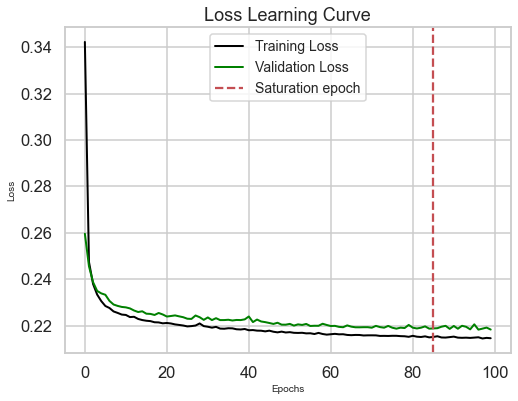

In [ ]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.savefig('figure/learning_curve.png')
plt.show()

<Figure size 432x288 with 0 Axes>

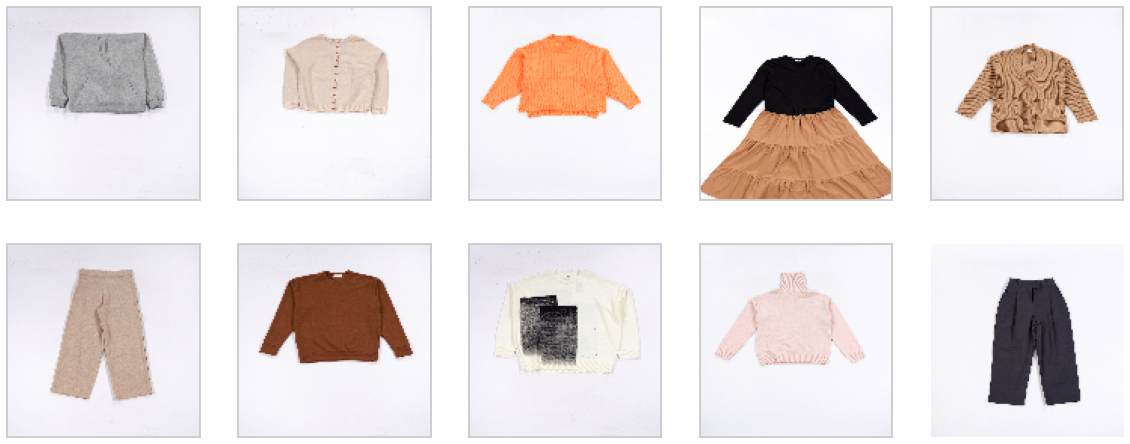

In [ ]:
# Test Image Samples
_ = plot_images(2,5,X_test)

<Figure size 432x288 with 0 Axes>

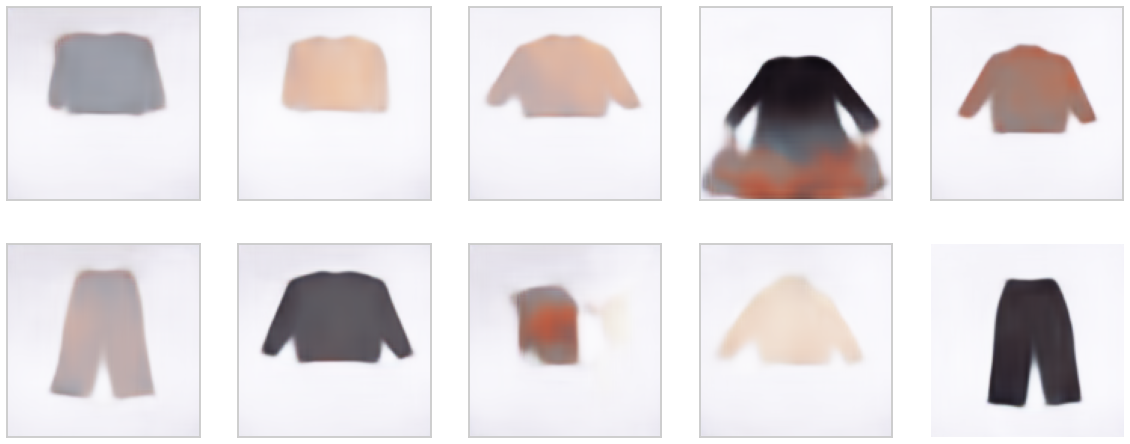

In [ ]:
# Prediction Image Samples
_ = plot_images(2,5,X_pred)

In [ ]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

104/104 [==============================] - 7s 61ms/step - loss: 0.2147
test loss : 0.2147


In [ ]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

2022-08-17 22:05:51.458289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


((3317, 128, 128, 3), 0.84)

In [ ]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(3317, list)

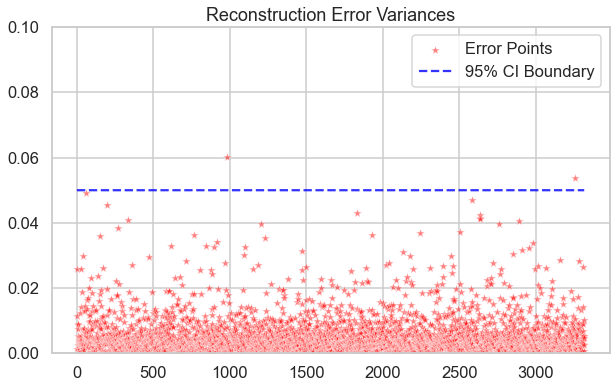

In [ ]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [ ]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

2022-08-17 22:06:30.639820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


((16585, 4, 4, 8), numpy.ndarray)

In [ ]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((16585, 8), numpy.ndarray)

In [ ]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.370932,0.0,1.324866,2.874785,1.015800,3.117471,0.562236,7.660734,0928015_F.jpg
1,0.367826,0.0,1.324293,2.842223,1.007168,3.090126,0.580176,7.568711,0929029_F.jpg
2,4.208163,0.0,2.103660,3.824102,1.716185,2.251197,4.871497,4.152266,1008001_F.jpg
3,2.747209,0.0,2.872785,4.024307,1.382814,2.648525,3.947344,5.101726,1008004_F.jpg
4,1.340298,0.0,2.733645,3.915232,1.458942,2.741291,2.850272,5.740139,1008006_F.jpg


In [ ]:
# Latent Feature DataFrame export to csv
df.to_csv('latent_feature_0818.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [ ]:
# Latent Feature DataFrame load
df = pd.read_csv('latent_feature_0818.csv')
print(df.shape)
df.head()

(16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.370932,0.0,1.324866,2.874785,1.015800,3.117471,0.562236,7.660734,0928015_F.jpg
1,0.367826,0.0,1.324293,2.842223,1.007168,3.090126,0.580176,7.568711,0929029_F.jpg
2,4.208163,0.0,2.103660,3.824102,1.716185,2.251197,4.871497,4.152266,1008001_F.jpg
3,2.747209,0.0,2.872785,4.024307,1.382814,2.648525,3.947344,5.101726,1008004_F.jpg
4,1.340298,0.0,2.733645,3.915232,1.458942,2.741291,2.850272,5.740139,1008006_F.jpg


In [ ]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(16585, 8) (16585,)


### Cosine Similarity

In [ ]:
data = data.astype('float32')

In [ ]:
# Cosine Similarity Computation
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(data, data)
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

cosine_matrix.shape : (16585, 16585)


array([[1.0000001 , 0.99999434, 0.708554  , 0.8294239 ],
       [0.99999434, 1.        , 0.710251  , 0.8309288 ],
       [0.708554  , 0.710251  , 1.        , 0.97170854],
       [0.8294239 , 0.8309288 , 0.97170854, 1.0000001 ]], dtype=float32)

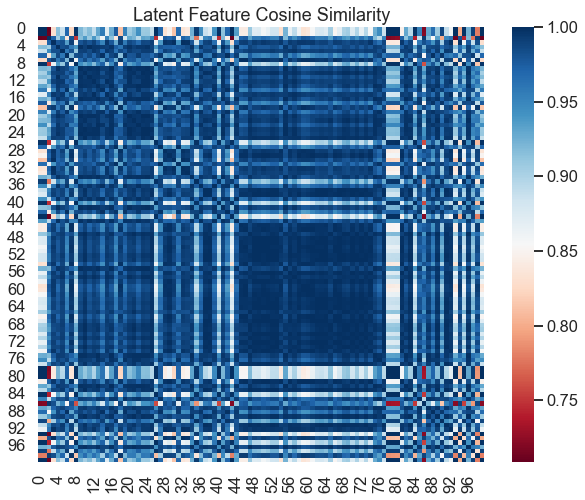

In [ ]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

sample_idx : 15795


In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 16585)


In [ ]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [ ]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (16585, 1)


,sample
0,0.996803
1,0.996992
2,0.753098
3,0.862422


In [ ]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
top10_label_cosine = label[top10_idx_cosine].values
print('top10_idx_cosine :',top10_idx_cosine)
print(top10_label_cosine)

top10_idx_cosine : Int64Index([15795, 12208, 8788, 15672, 13832, 8795, 13991, 13393, 14106,
            15696],
           dtype='int64')
['1210461_F.jpg' '1125150_F.jpg' '1112437_F.jpg' '1210284_F.jpg'
 '1202113_F.jpg' '1112445_F.jpg' '1202302_F.jpg' '1201003_F.jpg'
 '1202440_F.jpg' '1210312_F.jpg']


1210461_F.jpg


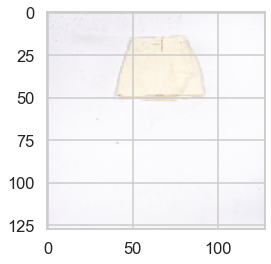

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

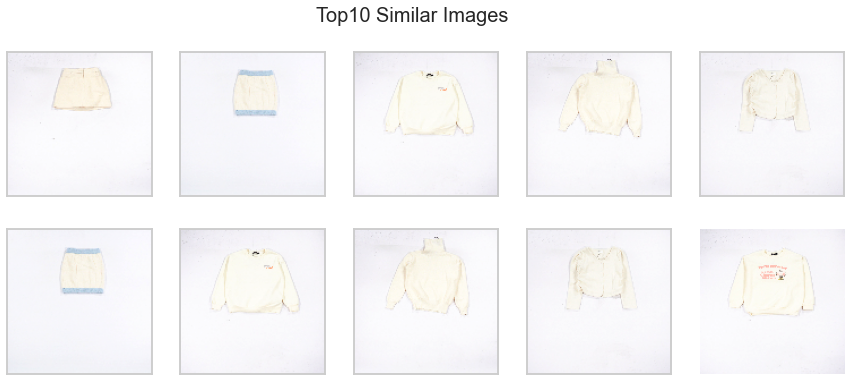

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [ ]:
# Euclidean Distance Calculation
from sklearn.metrics.pairwise import euclidean_distances

ec_matrix = 1 / euclidean_distances(data, data)
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

ec_matrix.shape : (16585, 16585)


array([[       inf, 9.675189  , 0.14381105, 0.18991296],
       [9.675189  ,        inf, 0.14492187, 0.19168288],
       [0.14381105, 0.14492187,        inf, 0.45688492],
       [0.18991296, 0.19168288, 0.45688492,        inf]], dtype=float32)

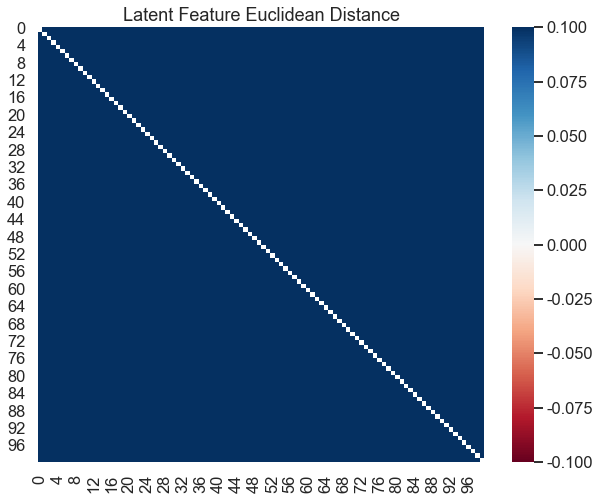

In [ ]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 16585)


In [ ]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (16585, 1)


,sample
0,1.255983
1,1.367924
2,0.158855
3,0.214811


In [ ]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([15795, 12208, 14106, 8795, 13991, 8788, 15675, 8786, 8793, 14889], dtype='int64')
['1210461_F.jpg' '1125150_F.jpg' '1202440_F.jpg' '1112445_F.jpg'
 '1202302_F.jpg' '1112437_F.jpg' '1210288_F.jpg' '1112434_F.jpg'
 '1112443_F.jpg' '1207394_F.jpg']


1210461_F.jpg


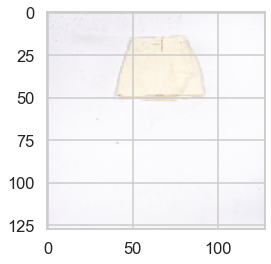

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

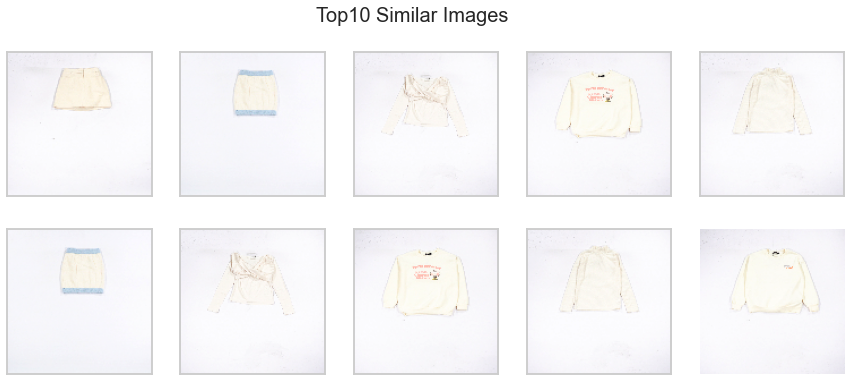

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [ ]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

pearson_sim.shape : (16585, 16585)


array([[1.        , 0.99999403, 0.33673785, 0.68457263],
       [0.99999403, 1.        , 0.33813127, 0.68610252],
       [0.33673785, 0.33813127, 1.        , 0.87086569],
       [0.68457263, 0.68610252, 0.87086569, 1.        ]])

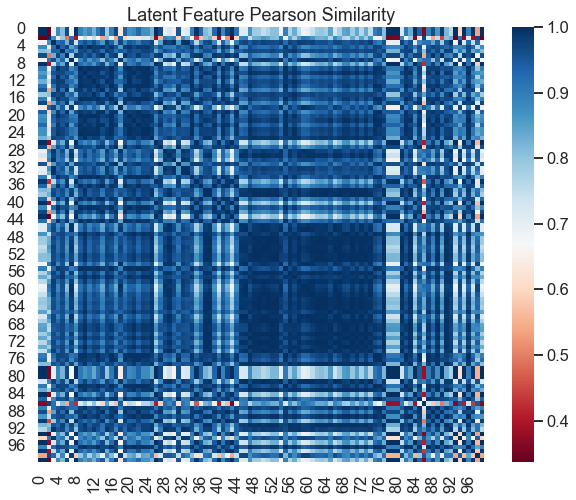

In [ ]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

sample_pearson_sim.shape : (16586, 16586)


In [ ]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

df_pearson.shape : (16585, 1)


,sample
0,0.995653
1,0.995830
2,0.402227
3,0.729669


In [ ]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

top10_idx_pearson : Int64Index([15795, 13832, 8788, 15672, 12208, 8786, 8795, 14106, 13393, 8793], dtype='int64')
['1210461_F.jpg' '1202113_F.jpg' '1112437_F.jpg' '1210284_F.jpg'
 '1125150_F.jpg' '1112434_F.jpg' '1112445_F.jpg' '1202440_F.jpg'
 '1201003_F.jpg' '1112443_F.jpg']


1210461_F.jpg


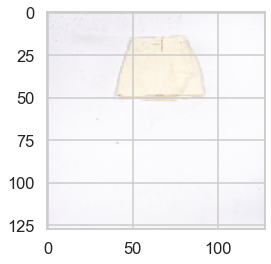

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

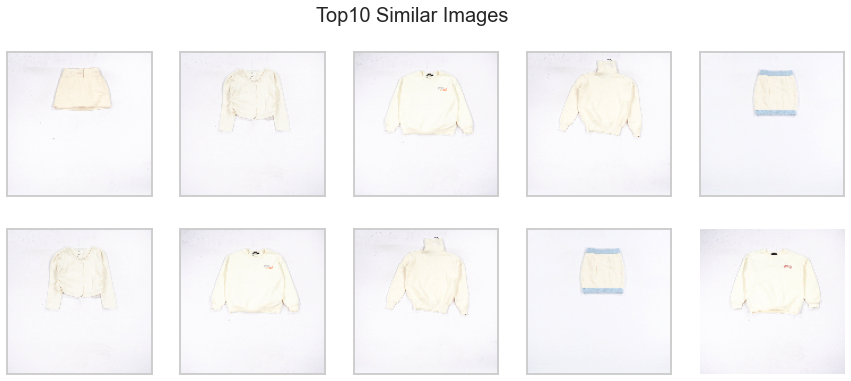

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)

## 7. Fashion Coordination Recommendation

### Fashion Coordination Dataframe Design

In [ ]:
# fashion coordination dataframe
fashion_df = pd.read_csv('fashion data/uni_wearing.csv')
print('fashion_df.shape :',fashion_df.shape)
fashion_df.head()

fashion_df.shape : (18040, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013.0,1008011,NaN,1008012.0,NaN
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449.0,1029157,NaN,1029107.0,NaN
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442.0,1029411,NaN,1029109.0,NaN
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434.0,1029073,NaN,1029141.0,NaN
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431.0,1029255,NaN,1029142.0,NaN


In [ ]:
# fashion dataframe Information
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wearing    18040 non-null  object 
 1   hat        32 non-null     float64
 2   main_top   18040 non-null  int64  
 3   inner_top  2838 non-null   float64
 4   bottom     16224 non-null  float64
 5   shoes      125 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 845.8+ KB


In [ ]:
# fashion dataframe 
print(fashion_df.isna().sum())

wearing          0
hat          18008
main_top         0
inner_top    15202
bottom        1816
shoes        17915
dtype: int64


In [ ]:
# fashion dataframe Missing Value Imputation
fashion_df.fillna(0,inplace=True)
print('Remain Missing Value :',fashion_df.isna().sum().sum())

Remain Missing Value : 0


In [ ]:
# fashion data preprocessing
fashion_df.iloc[:,1:] = fashion_df.iloc[:,1:].astype(int)
fashion_df.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442,1029411,0,1029109,0
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434,1029073,0,1029141,0
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431,1029255,0,1029142,0


### Match the coordination

In [ ]:
# top10 label by cosine similarity
top10_label_cosine

array(['1019386_B.jpg', '1116482_B.jpg', '1209174_F.jpg', '1116482_F.jpg',
       '1209174_B.jpg', '1127316_F.jpg', '1127316_B.jpg', '1102128_F.jpg',
       '1019386_F.jpg', '1126177_F.jpg'], dtype=object)

In [ ]:
# top10 label preprocessing
top10_result_cosine = list(map(lambda x : int(x[:7]), top10_label_cosine))
top10_result_cosine

[1019386,
 1116482,
 1209174,
 1116482,
 1209174,
 1127316,
 1127316,
 1102128,
 1019386,
 1126177]

In [ ]:
# top10 Recommendation Result
recomm_df = Fashion_coordination(top10_result_cosine, fashion_df)
print('recomm_df :',len(recomm_df),'DataFrame')
for i in range(len(recomm_df)):
  print(f"{i+1} item's coordination cases :",recomm_df[i].shape[0])

recomm_df : 10 DataFrame
1 item's coordination cases : 9
2 item's coordination cases : 8
3 item's coordination cases : 4
4 item's coordination cases : 8
5 item's coordination cases : 4
6 item's coordination cases : 12
7 item's coordination cases : 12
8 item's coordination cases : 10
9 item's coordination cases : 9
10 item's coordination cases : 1


In [ ]:
# First Similar Item Coordination Info
recomm_df[0].head()

,wearing,hat,main_top,inner_top,bottom,shoes
2225,1020_1020_720_A_A022_103_101_A022_000.jpg,0,1019415,0,1019386,0
2230,1020_1020_720_A_A028_108_101_A028_000.jpg,0,1019504,0,1019386,0
2444,1020_1020_720_C_C051_101_C051_000.jpg,0,1019495,0,1019386,0
2446,1020_1020_720_C_C053_088_101_C053_000.jpg,0,1019081,0,1019386,0
2448,1020_1020_720_C_C055_095_101_C055_000.jpg,0,1019257,0,1019386,0


### Recommendation Service Output Result

In [ ]:
pwd

'/content/drive/MyDrive/Code Lion/Final'

In [ ]:
root_dir

'/content/drive/MyDrive/Code Lion/Final/data'

In [ ]:
count = 0
fig = plt.figure()
fig, ax = plt.subplots(2,5,figsize=(5*3,2*3))
plt.suptitle('Fashion Best Fit Recommendatation!!')
for i in range(2):
  for j in range(5):
    axis = ax[i,j]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    fashion_img_name = recomm_df[count].iloc[0,0]
    try:
      img = img_read(root_dir + '/' + fashion_img_name)
      axis.imshow(img)
      plt.axis('off')
    except:
      pass
plt.show()

1
2
3
4
5
6
7
8
9
10
